In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd 
import os
import random

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import tensorflow as tf
from tensorflow_graph_in_jupyter import show_graph

/Users/Toshiaki/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data view

In [3]:
df = pd.read_csv("economicdata.csv")
df_2000 = df.iloc[:312,:]
df.iloc[300:315,]

,date,topix,exrate,indprod,cpi,saunemp,intrate
300,Jan-00,1657.91,98.03,96.91,100.163,4.7,0.02
301,Feb-00,1711.97,95.63,96.81,99.772,4.9,0.03
302,Mar-00,1661.73,98.87,98.21,99.967,4.9,0.02
303,Apr-00,1661.89,100.68,99.71,100.261,4.8,0.02
304,May-00,1595.11,100.34,99.11,100.359,4.6,0.02
305,Jun-00,1566.27,100.27,100.41,100.163,4.7,0.02
306,Jul-00,1552.98,99.13,100.21,99.772,4.7,0.02
307,Aug-00,1493.44,100.51,101.61,100.163,4.6,0.16
308,Sep-00,1483.96,103.54,99.51,99.967,4.7,0.25
309,Oct-00,1443.34,102.88,101.01,99.967,4.7,0.25


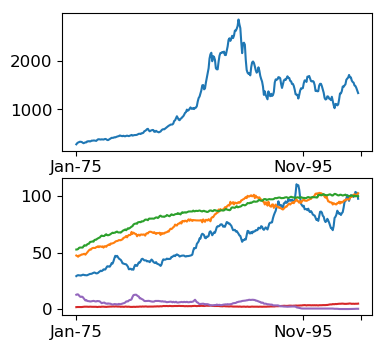

In [4]:
fig = plt.figure(figsize=(4,4),dpi=100)
ax1 = fig.add_subplot(2,1,1)
ax1.plot(df_2000.iloc[:,0],df_2000.iloc[:,1])
ax1.set_xticks([0, 250, 314])

ax2 = fig.add_subplot(2,1,2)
for key in df_2000.keys()[2:]:
    ax2.plot(df_2000.iloc[:,0],df_2000[key],label=key)
ax2.set_xticks([0, 250, 314])



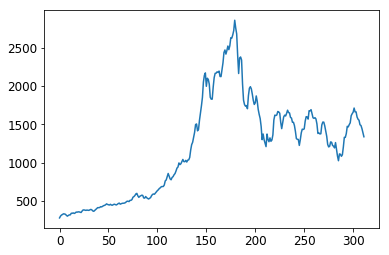

In [5]:
plt.plot(df_2000.iloc[:,1])

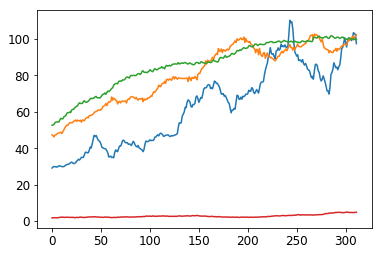

In [6]:
plt.plot(df_2000.iloc[:,2])
plt.plot(df_2000.iloc[:,3])
plt.plot(df_2000.iloc[:,4])
plt.plot(df_2000.iloc[:,5])

In [7]:
df[0:5]

,date,topix,exrate,indprod,cpi,saunemp,intrate
0,Jan-75,276.09,29.13,47.33,52.625,1.7,12.67
1,Feb-75,299.81,29.70,46.86,52.723,1.8,13.00
2,Mar-75,313.50,29.98,46.24,53.114,1.8,12.92
3,Apr-75,320.57,29.80,47.33,54.092,1.8,12.02
4,May-75,329.65,29.79,47.33,54.385,1.8,11.06


# RNN training section with economic data
    ## predict 3 step ahead ( 3 months ahead ) 

In [274]:
reset_graph()

n_steps=20
n_inputs=1
n_neurons=100
n_outputs = 3

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu ),
    output_size=n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [275]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [276]:
n_iterations = 1500
batch_size = 50
data = np.array(df.iloc[:,1])
model_path = "trained_model/economic_step3.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for ite in range(batch_size):
            rnd = random.randint(0,280)
            X_batch = np.hstack( (  X_batch , data[rnd:(rnd + 20)] ) )  
            for i in range(n_steps):
                y_batch=np.hstack( (  y_batch , data[(rnd+ i + 1):(rnd + i + 4)]  ) )
        X_batch = np.reshape(X_batch,[-1,20,1])
        y_batch = np.reshape(y_batch,[-1,20,3])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
                mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
                print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 1203059.0
100 	MSE: 16865.688
200 	MSE: 17584.104
300 	MSE: 15037.128
400 	MSE: 14694.394
500 	MSE: 16835.785
600 	MSE: 19751.836
700 	MSE: 14472.213
800 	MSE: 19801.982
900 	MSE: 15583.264
1000 	MSE: 13091.929
1100 	MSE: 15922.332
1200 	MSE: 10040.827
1300 	MSE: 17721.938
1400 	MSE: 13710.075


INFO:tensorflow:Restoring parameters from trained_model/economic_step3.ckpt
112376.56824441005
152396.64468505527


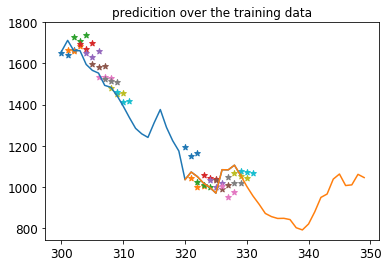

In [229]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(df.iloc[:,1])
SSE = 0 
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*20 for i in range(15,17)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30)])
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = test_data[(test_first - n_steps ):test_first].reshape([-1,20,1])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps)] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition over the training data")
            test_first +=1 
        print(SSE)

# RNN training section with economic data
    ## predict 3 step ahead ( 3 months ahead ) 
    ## with difference time series data 
        # note that predicting y21,y22,y23 with original sequence 
        # is equivalent to 
        # predicting yf20,yf21,yf22 with difference of original sequence.

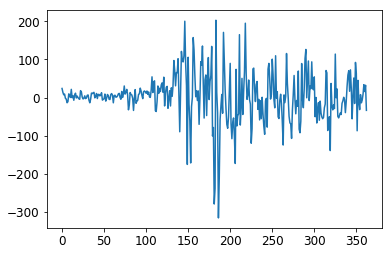

In [91]:
# data preparation 
dif_data = []
for i in range(1,df.shape[0]):
    dif_data.append( df.iloc[i,1] - df.iloc[i-1,1]) 
plt.plot(dif_data)

In [187]:
reset_graph()

n_steps=20
n_inputs=1
n_neurons=100
n_outputs = 3

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu ),
    output_size=n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [188]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [96]:
n_iterations = 1500
batch_size = 50
data = dif_data
model_path = "trained_model/economic_step3_dif.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for i in range(batch_size):
            rnd = random.randint(0,279)
            X_batch = np.hstack( (  X_batch , data[rnd:(rnd + 20)] ) )  
            for k in range(n_steps):
                y_batch=np.hstack( (  y_batch , data[(rnd+ k + 1):(rnd + k + 4)]  ) )
        X_batch = np.reshape(X_batch,[-1,20,1])
        y_batch = np.reshape(y_batch,[-1,20,3])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
                mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
                print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 4321.4385
100 	MSE: 2329.3142
200 	MSE: 481.87656
300 	MSE: 169.69482
400 	MSE: 161.46913
500 	MSE: 81.623886
600 	MSE: 57.189064
700 	MSE: 55.65552
800 	MSE: 51.561985
900 	MSE: 42.18023
1000 	MSE: 23.881987
1100 	MSE: 19.517595
1200 	MSE: 20.564322
1300 	MSE: 24.787214
1400 	MSE: 19.613111


INFO:tensorflow:Restoring parameters from trained_model/economic_step3_dif.ckpt
683.6005693216346
471.13480689331965
429.6711609596479
677.1827717114102
4061.183809152133
5918.9089384591425
2490.6834061928257
1724.130076312129


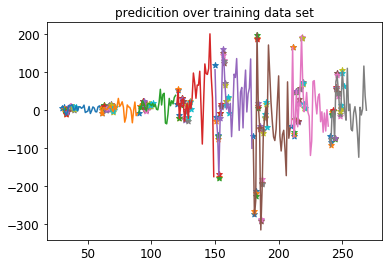

In [192]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(dif_data)
SSE = 0 
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3_dif.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*30 for i in range(1,9)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30)])
        
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = test_data[(test_first - n_steps ):test_first].reshape([-1,20,1])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps)] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition over training data set")
            test_first +=1 
        print(SSE)

INFO:tensorflow:Restoring parameters from trained_model/economic_step3_dif.ckpt
1902.9688271056586
1334.510277022999
1000.4556235324603
1145.2873811688137
11921.462910766038
17580.34322258831
6304.536948830926
2773.504551509243
1586.3144375475918
453722.55246284837


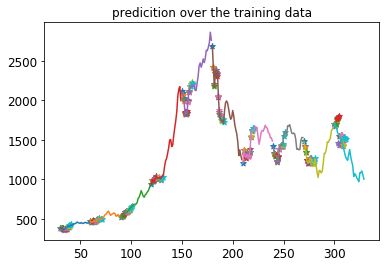

In [195]:
# for equally evaluating SSE
# generate original sequences from preditcted differences of topix data.


test_data = np.array(dif_data)
data = df.iloc[:,1]
SSE = 0 
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3_dif.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*30 for i in range(1,11)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,data[(test_first+1):(test_first + 31)])
        
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = test_data[(test_first - n_steps ):test_first].reshape([-1,20,1])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            y_pred_ori = np.array([data[test_first] + y_pred[0,-1,0],0,0])
                        # this first element predicts test_first + 1 index data in original sequence
            for i in range(2):
                y_pred_ori[i+1] = y_pred_ori[i] + y_pred[0,-1,i+1]
            SSE = SSE + sum(  ( data[(test_first+1) : (test_first+4)] - y_pred_ori )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred_ori,marker="*")
            plt.title("predicition over the training data")
            test_first +=1 
        print(SSE)

# RNN training section with economic data
    ## predict 3 step ahead ( 3 months ahead ) 
    ## with original and difference of time series data 
        # Pattern1  -> cost function includes only original sequence ( may be better than pattern2) 
        (# Pattern2  -> cost function includes original and dif of sequence  )


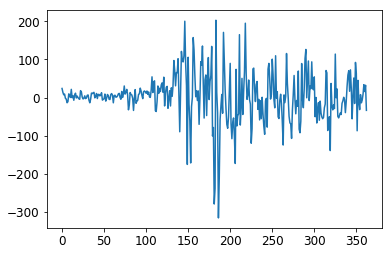

In [197]:
# data preparation
data = df.iloc[:,1]
dif_data = []
for i in range(1,df.shape[0]):
    dif_data.append( df.iloc[i,1] - df.iloc[i-1,1]) 
plt.plot(dif_data)

In [198]:
reset_graph()

n_steps=20
n_inputs=2
n_neurons=100
n_outputs = 3

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu ),
    output_size=n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [199]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [142]:
n_iterations = 1500
batch_size = 50
model_path = "trained_model/economic_step3_ori_dif.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for ite in range(batch_size):
            rnd = random.randint(1,279)
            for j in range(20):
                macro = np.array( [data[rnd+ j] , dif_data[rnd + j -1 ] ] )
                X_batch = np.hstack( (  X_batch , macro  ) )  
            for i in range(n_steps):
                y_batch=np.hstack( (  y_batch , data[(rnd+ i + 1):(rnd + i + 4)]  ) )
        X_batch = np.reshape(X_batch,[-1,20,n_inputs])
        y_batch = np.reshape(y_batch,[-1,20,n_outputs])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 1774569.0
100 	MSE: 21553.543
200 	MSE: 8253.699
300 	MSE: 9682.12
400 	MSE: 13265.238
500 	MSE: 12381.239
600 	MSE: 10033.267
700 	MSE: 5815.6
800 	MSE: 6657.7627
900 	MSE: 13910.319
1000 	MSE: 8880.556
1100 	MSE: 8478.84
1200 	MSE: 9004.405
1300 	MSE: 8710.167
1400 	MSE: 10848.499


INFO:tensorflow:Restoring parameters from trained_model/economic_step3_ori_dif.ckpt
117339.75250826047
200476.80075740544


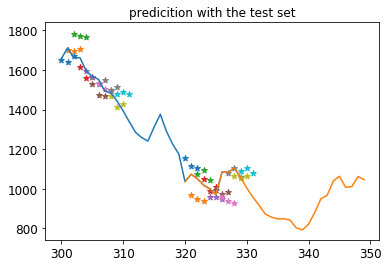

In [201]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(df.iloc[:,1])
test_dif_data = dif_data
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3_ori_dif.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*20 for i in range(15,17)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30)])
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = []
            for i in range( test_first- n_steps, test_first ):
                X_pred = np.hstack( (X_pred, test_data[i],test_dif_data[i -1 ]))
            X_pred = X_pred.reshape([-1,20,2])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps)] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition with the test set")
            test_first +=1 
        print(SSE)

# RNN training section with economic data
     predict 3 step ahead ( 3 months ahead ) 
     with original and difference of time series data 
        ( Pattern1  -> cost function includes only original sequence ( may be better than pattern2) )
         Pattern2  -> cost function includes original and dif of sequence  



In [202]:
reset_graph()

n_steps=20
n_inputs=2
n_neurons=100
n_outputs = 6

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu ),
    output_size=n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [203]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [149]:
n_iterations = 1500
batch_size = 50
model_path = "trained_model/economic_step3_ori_dif2.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for ite in range(batch_size):
            rnd = random.randint(1,279)
            for j in range(20):
                macro = np.array( [data[rnd+ j] , dif_data[rnd + j -1 ] ] )
                X_batch = np.hstack( (  X_batch , macro  ) )  
            for i in range(n_steps):
                y_batch=np.hstack( (  y_batch , data[(rnd+ i + 1):(rnd + i + 4)] ,  \
                                            dif_data[(rnd+ i ):(rnd + i + 3)]   ) )
        X_batch = np.reshape(X_batch,[-1,20,n_inputs])
        y_batch = np.reshape(y_batch,[-1,20,n_outputs])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 1044119.7
100 	MSE: 16964.19
200 	MSE: 14844.93
300 	MSE: 8439.991
400 	MSE: 9171.932
500 	MSE: 12658.021
600 	MSE: 11853.18
700 	MSE: 5186.3125
800 	MSE: 5395.16
900 	MSE: 9197.666
1000 	MSE: 9216.185
1100 	MSE: 8693.878
1200 	MSE: 9314.381
1300 	MSE: 8836.65
1400 	MSE: 6010.187


INFO:tensorflow:Restoring parameters from trained_model/economic_step3_ori_dif2.ckpt
9621.084350034987
2455.9954818553024
11185.570696647319
34357.60731416295
879176.7885849355
2520946.300118943
393831.7057833032
253762.5869906082
329513.4525286153
271543.8077749644


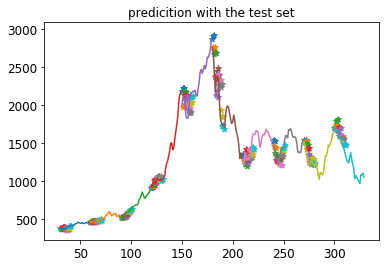

In [206]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(df.iloc[:,1])
test_dif_data = dif_data
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3_ori_dif2.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*30 for i in range(1,11)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30)])
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = []
            for i in range( test_first- n_steps, test_first ):
                X_pred = np.hstack( (X_pred, test_data[i],test_dif_data[i -1 ]))
            X_pred = X_pred.reshape([-1,20,2])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps)] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition with the test set")
            test_first +=1 
        print(SSE)

# RNN training section with economic data
    ## predict 3 step ahead ( 3 months ahead ) 
    ## with original and difference of time series data 
        # Pattern1  -> cost function includes only original sequence ( may be better than pattern2) 
    ## limit trainig data from Jan-92 (204) to Dec-99  

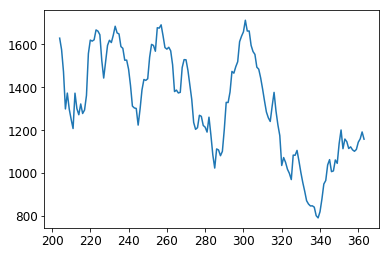

In [158]:
plt.plot(df.iloc[204:,1])

In [207]:
reset_graph()

n_steps=20
n_inputs=2
n_neurons=100
n_outputs = 3

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu ),
    output_size=n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [208]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [162]:
n_iterations = 1500
batch_size = 50
model_path = "trained_model/economic_step3_ori_dif_lim.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for ite in range(batch_size):
            rnd = random.randint(204,279)
            for j in range(20):
                macro = np.array( [data[rnd+ j] , dif_data[rnd + j -1 ] ] )
                X_batch = np.hstack( (  X_batch , macro  ) )  
            for i in range(n_steps):
                y_batch=np.hstack( (  y_batch , data[(rnd+ i + 1):(rnd + i + 4)]  ) )
        X_batch = np.reshape(X_batch,[-1,20,n_inputs])
        y_batch = np.reshape(y_batch,[-1,20,n_outputs])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 1618382.6
100 	MSE: 16949.824
200 	MSE: 12277.712
300 	MSE: 10918.845
400 	MSE: 8776.783
500 	MSE: 7623.9775
600 	MSE: 10749.108
700 	MSE: 8943.591
800 	MSE: 6506.7373
900 	MSE: 8260.972
1000 	MSE: 8704.29
1100 	MSE: 7143.6406
1200 	MSE: 5365.977
1300 	MSE: 3827.5696
1400 	MSE: 4453.0835


INFO:tensorflow:Restoring parameters from trained_model/economic_step3_ori_dif_lim.ckpt
116236.19319896269
383525.4784556598


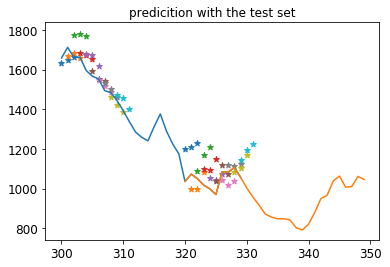

In [209]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(df.iloc[:,1])
test_dif_data = dif_data
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3_ori_dif_lim.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*20 for i in range(15,17)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30)])
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = []
            for i in range( test_first- n_steps, test_first ):
                X_pred = np.hstack( (X_pred, test_data[i],test_dif_data[i -1 ]))
            X_pred = X_pred.reshape([-1,20,2])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps)] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition with the test set")
            test_first +=1 
        print(SSE)

# RNN training section with economic data
    ## predict 3 step ahead ( 3 months ahead ) 
    ## with original and difference of time series data 
        # Pattern1  -> cost function includes only original sequence ( may be better than pattern2) 
    ## using reshape method, not using outputwrappterprojection

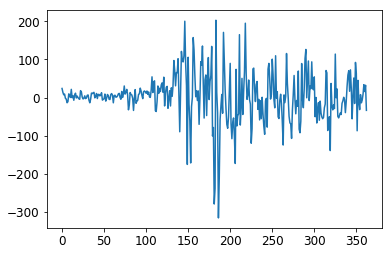

In [210]:
# data preparation
data = df.iloc[:,1]
dif_data = []
for i in range(1,df.shape[0]):
    dif_data.append( df.iloc[i,1] - df.iloc[i-1,1]) 
plt.plot(dif_data)

In [211]:
reset_graph()

n_steps=20
n_inputs=2
n_neurons=100
n_outputs = 3

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell =  tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu )
rnn_outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs,[-1,n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs,n_outputs)
outputs = tf.reshape(stacked_outputs,[-1,n_steps,n_outputs])

In [212]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [174]:
n_iterations = 1500
batch_size = 50
model_path = "trained_model/economic_step3_ori_dif_lim_with_stack.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for ite in range(batch_size):
            rnd = random.randint(1,279)
            for j in range(20):
                macro = np.array( [data[rnd+ j] , dif_data[rnd + j -1 ] ] )
                X_batch = np.hstack( (  X_batch , macro  ) )  
            for i in range(n_steps):
                y_batch=np.hstack( (  y_batch , data[(rnd+ i + 1):(rnd + i + 4)]  ) )
        X_batch = np.reshape(X_batch,[-1,20,n_inputs])
        y_batch = np.reshape(y_batch,[-1,20,n_outputs])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 1364406.4
100 	MSE: 24143.89
200 	MSE: 24992.34
300 	MSE: 10984.204
400 	MSE: 10758.19
500 	MSE: 5920.686
600 	MSE: 10073.789
700 	MSE: 10905.518
800 	MSE: 7034.7144
900 	MSE: 8265.521
1000 	MSE: 6272.3125
1100 	MSE: 9419.261
1200 	MSE: 5505.817
1300 	MSE: 4019.5889
1400 	MSE: 7978.2573


INFO:tensorflow:Restoring parameters from trained_model/economic_step3_ori_dif_lim_with_stack.ckpt
634255.4764835971
378100.7302971254


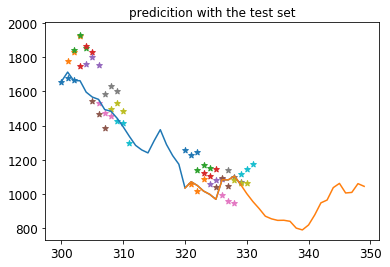

In [213]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(df.iloc[:,1])
test_dif_data = dif_data
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3_ori_dif_lim_with_stack.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*20 for i in range(15,17)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30)])
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = []
            for i in range( test_first- n_steps, test_first ):
                X_pred = np.hstack( (X_pred, test_data[i],test_dif_data[i -1 ]))
            X_pred = X_pred.reshape([-1,20,2])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps)] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition with the test set")
            test_first +=1 
        print(SSE)

In [214]:
reset_graph()

n_steps=20
n_inputs=1
n_neurons=100
n_outputs = 3

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu ),
    output_size=n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)


In [215]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [217]:
n_iterations = 1500
batch_size = 50
data = np.array(df.iloc[:,1])
model_path = "trained_model/economic_step3_lim.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for i in range(batch_size):
            rnd = random.randint(204,280)
            X_batch = np.hstack( (  X_batch , data[rnd:(rnd + 20)] ) )  
            for i in range(n_steps):
                y_batch=np.hstack( (  y_batch , data[(rnd+ i + 1):(rnd + i + 4)]  ) )
        X_batch = np.reshape(X_batch,[-1,20,1])
        y_batch = np.reshape(y_batch,[-1,20,3])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
                mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
                print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 1582415.4
100 	MSE: 22522.78
200 	MSE: 21866.766
300 	MSE: 13359.854
400 	MSE: 11456.293
500 	MSE: 13159.345
600 	MSE: 10776.92
700 	MSE: 8347.753
800 	MSE: 9100.132
900 	MSE: 8647.803
1000 	MSE: 8553.19
1100 	MSE: 8792.798
1200 	MSE: 9783.644
1300 	MSE: 9692.207
1400 	MSE: 7200.17


INFO:tensorflow:Restoring parameters from trained_model/economic_step3_lim.ckpt
267459.88973137067
321195.04563009215


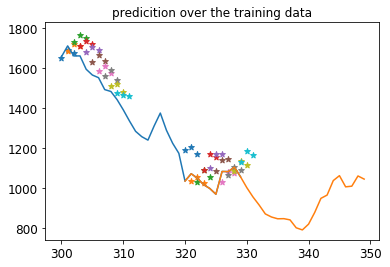

In [219]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(df.iloc[:,1])
SSE = 0 
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3_lim.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*20 for i in range(15,17)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30)])
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = test_data[(test_first - n_steps ):test_first].reshape([-1,20,1])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps)] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition over the training data")
            test_first +=1 
        print(SSE)

# RNN training section with economic data
    ## predict 3 step ahead ( 3 months ahead ) 
    ## using reshape method, not using outputwrappterprojection

In [238]:
reset_graph()

n_steps=20
n_inputs=1
n_neurons=100
n_outputs = 3

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell =  tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu )
rnn_outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs,[-1,n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs,n_outputs)
outputs = tf.reshape(stacked_outputs,[-1,n_steps,n_outputs])

In [239]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [236]:
n_iterations = 1500
batch_size = 50
model_path = "trained_model/economic_step3_dense.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for ite in range(batch_size):
            rnd = random.randint(1,279)
            X_batch = np.hstack( (  X_batch , data[rnd:(rnd + 20)] ) )  
            for i in range(n_steps):
                y_batch=np.hstack( (  y_batch , data[(rnd+ i + 1):(rnd + i + 4)]  ) )
        X_batch = np.reshape(X_batch,[-1,20,n_inputs])
        y_batch = np.reshape(y_batch,[-1,20,n_outputs])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 1714125.6
100 	MSE: 23816.746
200 	MSE: 21394.58
300 	MSE: 27170.44
400 	MSE: 17896.65
500 	MSE: 16097.767
600 	MSE: 12024.129
700 	MSE: 17939.482
800 	MSE: 19699.193
900 	MSE: 8263.167
1000 	MSE: 14235.981
1100 	MSE: 9040.774
1200 	MSE: 26112.29
1300 	MSE: 9846.491
1400 	MSE: 6565.682


INFO:tensorflow:Restoring parameters from trained_model/economic_step3_dense.ckpt
135059.03002403065
168529.20916751277


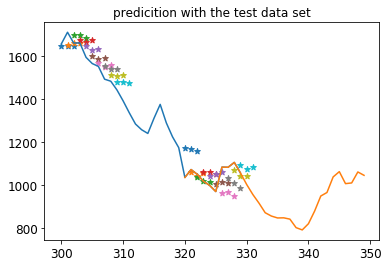

In [241]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(df.iloc[:,1])
SSE = 0 
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3_dense.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*20 for i in range(15,17)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30)])
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = test_data[(test_first - n_steps ):test_first].reshape([-1,20,1])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps)] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition with the test data set")
            test_first +=1 
        print(SSE)

# RNN training section with economic data
    ## predict 3 step ahead ( 3 months ahead )
    ## with other economic indexes

In [250]:
reset_graph()

n_steps=20
n_inputs=6
n_neurons=100
n_outputs = 3

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu ),
    output_size=n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [251]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [257]:
n_iterations = 1500
batch_size = 50
data = np.array(df)
model_path = "trained_model/economic_step3_var6.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for ite in range(batch_size):
            rnd = random.randint(0,280)
            for i in range(n_steps):
                for j in range(1,data.shape[1]):
                    X_batch = np.hstack( (  X_batch , data[(rnd+ i),j] ) ) 
                y_batch=np.hstack( (  y_batch , data[(rnd+ i + 1):(rnd + i + 4),1]  ) )
        X_batch = np.reshape(X_batch,[-1,20,n_inputs])
        y_batch = np.reshape(y_batch,[-1,20,n_outputs])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
                mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
                print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 962614.3
100 	MSE: 40883.48
200 	MSE: 26524.678
300 	MSE: 16255.11
400 	MSE: 8723.811
500 	MSE: 19285.418
600 	MSE: 17355.441
700 	MSE: 14421.48
800 	MSE: 12385.862
900 	MSE: 15470.477
1000 	MSE: 8438.711
1100 	MSE: 6485.566
1200 	MSE: 12990.304
1300 	MSE: 9740.591
1400 	MSE: 11526.377


INFO:tensorflow:Restoring parameters from trained_model/economic_step3_var6.ckpt
69829.14449888519
188059.66100210138


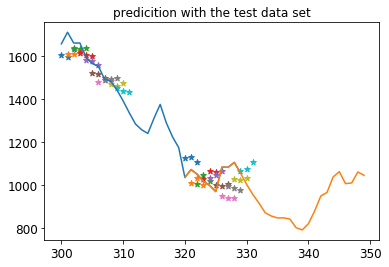

In [262]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(df)
SSE = 0 
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3_var6.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*20 for i in range(15,17)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30),1])
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = []
            for i in range(n_steps):
                for j in range(1,data.shape[1]):
                    X_pred = np.hstack(( X_pred, test_data[(test_first - n_steps +i ),j] ))
            X_pred = X_pred.reshape([-1,20,n_inputs])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps),1] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition with the test data set")
            test_first +=1 
        print(SSE)

# RNN training section with economic data
    ## predict 12 step ahead ( 12 months ahead )
    ## with other economic indexes

In [264]:
reset_graph()

n_steps=20
n_inputs=6
n_neurons=100
n_outputs = 12

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu ),
    output_size=n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [265]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [266]:
n_iterations = 1500
batch_size = 50
data = np.array(df)
model_path = "trained_model/economic_step12_var6.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for ite in range(batch_size):
            rnd = random.randint(0,268)
            for i in range(n_steps):
                for j in range(1,data.shape[1]):
                    X_batch = np.hstack( (  X_batch , data[(rnd+ i),j] ) ) 
                y_batch=np.hstack( (  y_batch , data[(rnd+ i + 1):(rnd + i + 13),1]  ) )
        X_batch = np.reshape(X_batch,[-1,20,n_inputs])
        y_batch = np.reshape(y_batch,[-1,20,n_outputs])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
                mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
                print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 1409100.6
100 	MSE: 69190.664
200 	MSE: 59983.574
300 	MSE: 66749.39
400 	MSE: 59829.266
500 	MSE: 54614.9
600 	MSE: 55855.555
700 	MSE: 67057.875
800 	MSE: 51220.82
900 	MSE: 49778.81
1000 	MSE: 33717.62
1100 	MSE: 58440.773
1200 	MSE: 35754.105
1300 	MSE: 52103.887
1400 	MSE: 48174.336


INFO:tensorflow:Restoring parameters from trained_model/economic_step12_var6.ckpt
200325.6566905899
153939.69782553727
125326.06354173587
1459749.2108767899
9572364.21171117
23236396.17474022
6028583.608325733
3572982.5253814333
5480910.01532998
12000286.841819167


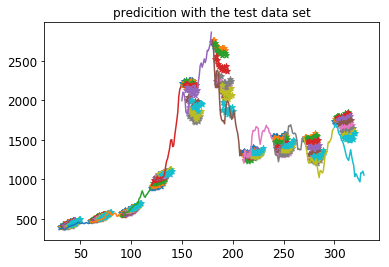

In [273]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(df)
SSE = 0 
n_steps = 20
n_pred_steps = 12
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step12_var6.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*30 for i in range(1,11)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30),1])
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = []
            for i in range(n_steps):
                for j in range(1,data.shape[1]):
                    X_pred = np.hstack(( X_pred, test_data[(test_first - n_steps +i ),j] ))
            X_pred = X_pred.reshape([-1,20,n_inputs])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps),1] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition with the test data set")
            test_first +=1 
        print(SSE)

# Creative RNN

In [295]:
reset_graph()

n_steps=20
n_inputs=1
n_neurons=100
n_outputs = 3

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell( num_units=n_neurons , activation=tf.nn.relu ),
    output_size=n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [296]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [316]:
model = "trained_model/economic_step3.ckpt"

with tf.Session() as sess:
    saver.restore(sess, model)
    
    sequence = [50.]*n_steps
    for iteration in range(50):
        X_batch= np.array(sequence[-n_steps:]).reshape(1,n_steps,1)
        y_pred  =sess.run(outputs,feed_dict={X:X_batch})
        sequence.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from trained_model/economic_step3.ckpt


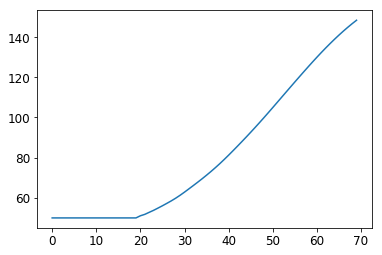

In [317]:
plt.plot(sequence)

# LSTM cell 

In [8]:
reset_graph()

n_steps=20
n_inputs=6
n_neurons=100
n_outputs = 3

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

# wrap outputneurons by dense layer and make one output for each time step
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell( num_units=n_neurons , activation=tf.nn.relu ),
    output_size=n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [9]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs[:,19,:] - y[:,19,:] ))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the training data 
saver = tf.train.Saver()

In [26]:
n_iterations = 10000
batch_size = 50
data = np.array(df)
model_path = "trained_model/economic_step3_lstm.ckpt"

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # data input phase 
        X_batch = []
        y_batch = []
        for ite in range(batch_size):
            rnd = random.randint(0,280)
            for i in range(n_steps):
                for j in range(1,data.shape[1]):
                    X_batch = np.hstack( (  X_batch , data[(rnd+ i),j] ) ) 
                y_batch=np.hstack( (  y_batch , data[(rnd+ i + 1):(rnd + i + 4),1]  ) )
        X_batch = np.reshape(X_batch,[-1,20,n_inputs])
        y_batch = np.reshape(y_batch,[-1,20,n_outputs])
        
        sess.run(training_op,feed_dict= { X: X_batch, y: y_batch })
        if iteration % 100 == 0 :
                mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
                print(iteration,"\tMSE:",mse)
    save_path = saver.save(sess,model_path)

0 	MSE: 1911116.0
100 	MSE: 316940.62
200 	MSE: 1057021.6
300 	MSE: 322939.2
400 	MSE: 277438.66
500 	MSE: 214361.73
600 	MSE: 160884.11
700 	MSE: 210413.78
800 	MSE: 131334.86
900 	MSE: 166718.36
1000 	MSE: 62213.633
1100 	MSE: 134606.38
1200 	MSE: 235263.52
1300 	MSE: 288063.1
1400 	MSE: 142561.52
1500 	MSE: 51593.586
1600 	MSE: 126859.13
1700 	MSE: 39665.387
1800 	MSE: 185864.95
1900 	MSE: 245594.3
2000 	MSE: 660150.9
2100 	MSE: 88862.914
2200 	MSE: 88525.48
2300 	MSE: 93205.71
2400 	MSE: 77989.47
2500 	MSE: 132655.6
2600 	MSE: 74251.266
2700 	MSE: 36436.51
2800 	MSE: 31531.34
2900 	MSE: 58677.895
3000 	MSE: 80487.53
3100 	MSE: 87771.24
3200 	MSE: 210160.94
3300 	MSE: 168948.53
3400 	MSE: 52932.586
3500 	MSE: 60650.94
3600 	MSE: 54695.168
3700 	MSE: 54557.12
3800 	MSE: 46754.582
3900 	MSE: 275807.6
4000 	MSE: 61217.48
4100 	MSE: 61483.867
4200 	MSE: 36485.39
4300 	MSE: 40264.246
4400 	MSE: 59350.83
4500 	MSE: 22814.186
4600 	MSE: 40727.285
4700 	MSE: 113539.375
4800 	MSE: 48362.293


INFO:tensorflow:Restoring parameters from trained_model/economic_step3_lstm.ckpt
2178978.752061927
1200882.430313846


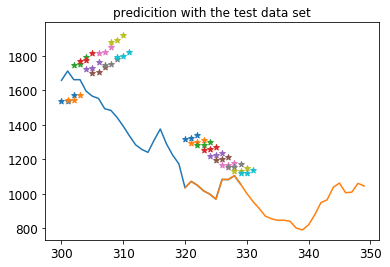

In [29]:
'''
    unrolling test method 
1.give test_first index. 
2.predict with n_steps data before test_first 
3.take SSE between prediction and test data for n_pred_steps data 
4.plus 1 to test_fisrt index, and do 1-3 
5. do 1-4 for n_times_eval times. 
'''


test_data = np.array(df)
SSE = 0 
n_steps = 20
n_pred_steps = 3
test_first = 300
n_times_eval = 10

model = "trained_model/economic_step3_lstm.ckpt"
#check_value = [i for i in np.linspace(300,381,1)]
check_value = [i*20 for i in range(15,17)]
with tf.Session() as sess:
    saver.restore(sess, model)
    for test_first in check_value:
        test_first = int(test_first)
        SSE=0
        
        t = [i for i in range(test_first,(test_first + 30))]
        plt.plot(t,test_data[test_first:(test_first + 30),1])
        for k,iteration in enumerate( range(n_times_eval) ) :
            X_pred = []
            for i in range(n_steps):
                for j in range(1,data.shape[1]):
                    X_pred = np.hstack(( X_pred, test_data[(test_first - n_steps +i ),j] ))
            X_pred = X_pred.reshape([-1,20,n_inputs])
            y_pred = sess.run(outputs,feed_dict={X:X_pred})
            SSE = SSE + sum(  ( y_pred[0][-1][:n_pred_steps] - test_data[test_first:(test_first + n_pred_steps),1] )**2 )

            x =np.array([i for i in  range(n_pred_steps)])
            plt.scatter(test_first+x,y_pred[0][-1][:n_pred_steps],marker="*")
            plt.title("predicition with the test data set")
            test_first +=1 
        print(SSE)

In [10]:
show_graph(tf.get_default_graph())